# 1. Link weather data to categorized credit card statements and create a prediction model for likelihood of going grocery shopping

## 1.1. Steps involved:
1. Import the categorized CC statements(CCS) data
2. Import the weather data for the transaction time period in the pertaining region
3. Join the weather data onto the CCS data
4. Wrangle CCS data and add the following columns:
    a. Number of days since last grocery shopping trip
    b. The amount of last grocery shopping
    c. Number of days since you last ordered from a restaurant
    d. The amount of last restaurant order (>=$20, to keep out petty orders and coffees)
5. Carry out EDA to find the relationship between variables
6. Add new metrics if needed and split train and test data
7. Build regression models to predict next grocery shopping expense
8. Choose the variables and create a timeseries model for predicting the next shopping trip
9. Tune and select the model

#### Libraries
Import necessary libraries, set working directory and plot themes.
 - pandas, datetime and numpy for data manipulation
 - seaborn and matplotlib for plots
 - sklearn and statsmodels for modeling
 - scipy for data transformations and statistical functions

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.special import boxcox, inv_boxcox
import scipy.stats as stats

# Set working directory
os.chdir(r"--- Your path here--- ")
print(os.getcwd())

# Set theme for sns plots
sns.set_theme(style="darkgrid")

FileNotFoundError: [WinError 2] The system cannot find the file specified: '--- Your path here--- '

#### Import data
- Import categorized credit card transaction data and weather data for 2019,2020 and 2021.
- Set the date columns to datetime format and rename or drop columns as needed in both datasets
- Join weather data on to credit card transaction data so we have the weather data for each day there was a credit card transaction

In [2]:
# Import the categorized CCS data
CCdata = pd.read_csv("CompleteCCStatements.csv",header=0, index_col=False)
CCdata.drop_duplicates(subset=None,keep='first',inplace=True)
print(CCdata.shape)

(759, 7)


In [3]:
# Import weather data
weather2019 = pd.read_csv("en_climate_daily_ON_6153193_2019_P1D.csv",header=0)
print(weather2019.shape)

weather2020 = pd.read_csv("en_climate_daily_ON_6153193_2020_P1D.csv",header=0)
print(weather2020.shape)

weather2021 = pd.read_csv("en_climate_daily_ON_6153193_2021_P1D.csv",header=0)
print(weather2021.shape)

# Combine the individual years' weather data into a single df
weatherData = weather2019.append([weather2020,weather2021],ignore_index=True)
print(weatherData.shape)

# Examining the columns in the weather data
print(weatherData.head(20))
print(weatherData.columns)
print(weatherData.dtypes)
## Wow! the data is mostly clean :-)

(365, 31)
(366, 31)
(365, 31)
(1096, 31)
    Longitude (x)  Latitude (y) Station Name  Climate ID   Date/Time  Year  \
0          -79.94         43.17   HAMILTON A     6153193  2019-01-01  2019   
1          -79.94         43.17   HAMILTON A     6153193  2019-01-02  2019   
2          -79.94         43.17   HAMILTON A     6153193  2019-01-03  2019   
3          -79.94         43.17   HAMILTON A     6153193  2019-01-04  2019   
4          -79.94         43.17   HAMILTON A     6153193  2019-01-05  2019   
5          -79.94         43.17   HAMILTON A     6153193  2019-01-06  2019   
6          -79.94         43.17   HAMILTON A     6153193  2019-01-07  2019   
7          -79.94         43.17   HAMILTON A     6153193  2019-01-08  2019   
8          -79.94         43.17   HAMILTON A     6153193  2019-01-09  2019   
9          -79.94         43.17   HAMILTON A     6153193  2019-01-10  2019   
10         -79.94         43.17   HAMILTON A     6153193  2019-01-11  2019   
11         -79.94      

In [4]:
# Set the date column in weather data as a datetime object and then as index of df
weatherData['Date'] = pd.to_datetime(weatherData['Date/Time'], format="%Y-%m-%d")
print(weatherData.dtypes)

weatherData = weatherData.set_index('Date')
weatherData.head(5)

weatherData = weatherData.rename({'Max Temp (°C)':'MaxTemp', 
                                  'Min Temp (°C)':'MinTemp',
                                  'Mean Temp (°C)':'MeanTemp',
                                 'Heat Deg Days (°C)':'HeatDegDays',
                                 'Cool Deg Days (°C)':'CoolDegDays',
                                 'Total Precip (mm)':'TotalPrecip',
                                  'Total Rain (mm)':'TotalRain',
                                  'Total Snow (cm)':'TotalSnow',
                                  'Snow on Grnd (cm)':'SnowGrnd',
                                  'Spd of Max Gust (km/h)':'MaxGust'}, axis=1)

weatherData['TempDiff'] = weatherData['MaxTemp'] - weatherData['MinTemp']

statCols = ['TotalPrecip','TotalRain','TotalSnow','SnowGrnd',
            'MaxGust','MaxTemp','MinTemp','TempDiff','MeanTemp']

print(weatherData[statCols].describe())

# Fill Nans with the previous non-Nan value in the following columns - coz they are to be used in regression modelling
print("The percentage of null values in each column: \n",weatherData[['MaxGust','MeanTemp','TempDiff']].isnull().mean()*100)
weatherData['MaxGust'] = weatherData['MaxGust'].fillna(method="ffill")
weatherData['MeanTemp'] = weatherData['MeanTemp'].fillna(method="ffill")
weatherData['TempDiff'] = weatherData['TempDiff'].fillna(method="ffill")

Longitude (x)                       float64
Latitude (y)                        float64
Station Name                         object
Climate ID                            int64
Date/Time                            object
Year                                  int64
Month                                 int64
Day                                   int64
Data Quality                        float64
Max Temp (°C)                       float64
Max Temp Flag                        object
Min Temp (°C)                       float64
Min Temp Flag                        object
Mean Temp (°C)                      float64
Mean Temp Flag                       object
Heat Deg Days (°C)                  float64
Heat Deg Days Flag                   object
Cool Deg Days (°C)                  float64
Cool Deg Days Flag                   object
Total Rain (mm)                     float64
Total Rain Flag                      object
Total Snow (cm)                     float64
Total Snow Flag                 

Links:
1. Canadian weather data download:
a. Hourly data: https://climate.weather.gc.ca/historical_data/search_historic_data_e.html?Month=2&Day=16&Year=2022&timeframe=2&StartYear=1840&EndYear=2022
b. Daily data: https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=49908
2. Classifying a storm based on wind and temp data: https://geo-python.github.io/site/notebooks/L6/pandas/advanced-data-processing-with-pandas.html
3. Time series basic tutorial: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
4. Python merge vs join vs concat: https://realpython.com/pandas-merge-join-and-concat/
5. Python how to lag or lead time series: https://setscholars.net/data-wrangling-in-python-how-to-group-a-time-series-with-pandas/
6. Dealing with missing values in pandas - forward and backward fill, intrapolating: https://www.projectpro.io/recipes/deal-with-missing-values-in-timeseries-in-python
7. Handle time series with ease: https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html
8. Date functionality and conversions in time series: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
9. Groupby 1 column and sum rest of the columns: https://stackoverflow.com/questions/25536032/pandas-group-by-and-sum-two-columns
10. Create pivot table from df: https://stackoverflow.com/questions/48768650/groupby-sum-and-count-on-multiple-columns-in-python
11. Bivariate analysis in python: https://www.analyticsvidhya.com/blog/2022/02/a-quick-guide-to-bivariate-analysis-in-python/
12. Detailed Pandas groupby and agg function: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/ 
13. Scal, centre and box-cox transform in R and python: https://stackoverflow.com/questions/33944129/python-library-for-data-scaling-centering-and-box-cox-transformation

In [5]:
print(CCdata['Transaction Date'].dtype)
print(CCdata.loc[0:1,'Transaction Date'])
print(CCdata['Year'].dtype)
print(CCdata.loc[0:1,'Year'])

# Create a date column in CCdata by combining date,month and year
# Separate day and month
CCdata['Day'] = CCdata['Transaction Date'].str.extract('([0-9]+)',expand=False)
print(CCdata['Day'].head(10))
print(CCdata['Day'].value_counts())
CCdata['Month'] = CCdata['Transaction Date'].str.extract('([A-Za-z]+)',expand=False)
print(CCdata['Month'].head(10))
print(CCdata['Month'].value_counts())

# Combine day,month and year to form the date column
cols = ['Day','Month','Year']
CCdata['Date'] = CCdata[cols].astype(str).apply('-'.join, axis=1)
print(CCdata['Date'].head(10))

# Setting the date column to type datatime64 and as index of the df
CCdata['Date'] = pd.to_datetime(CCdata['Date'], format="%d-%b-%Y")
CCdata['Weekday'] = CCdata['Date'].dt.day_name()
print(CCdata.dtypes)
CCdata = CCdata.set_index('Date')
print(CCdata.shape)
print(CCdata.head(5))

object
0    1-Feb
1    3-Feb
Name: Transaction Date, dtype: object
int64
0    2020
1    2020
Name: Year, dtype: int64
0     1
1     3
2    11
3    15
4    16
5    16
6    17
7    17
8    17
9    20
Name: Day, dtype: object
13    42
24    34
5     32
20    31
8     28
23    28
1     28
29    27
7     27
2     26
6     26
17    26
26    25
3     25
25    25
4     24
28    23
30    23
10    23
14    23
27    22
22    22
15    22
16    21
21    21
12    20
18    20
19    19
9     18
11    14
31    14
Name: Day, dtype: int64
0    Feb
1    Feb
2    Oct
3    Oct
4    Oct
5    Oct
6    Oct
7    Oct
8    Oct
9    Oct
Name: Month, dtype: object
Sep    103
Aug     94
Jul     90
Jun     82
May     73
Oct     70
Feb     69
Mar     69
Nov     33
Jan     28
Dec     26
Apr     22
Name: Month, dtype: int64
0     1-Feb-2020
1     3-Feb-2020
2    11-Oct-2020
3    15-Oct-2020
4    16-Oct-2020
5    16-Oct-2020
6    17-Oct-2020
7    17-Oct-2020
8    17-Oct-2020
9    20-Oct-2020
Name: Date, dtype: object
Tra

In [6]:
# Sorting CC data by date before proceeding
CCdata = CCdata.sort_index()

# Joining weather data with the CC data based on date
requiredCols = ['TotalPrecip','TotalRain','TotalSnow','SnowGrnd',
            'MaxGust','MaxTemp','MinTemp','TempDiff','MeanTemp']
requiredWeatherData = weatherData[requiredCols]
print(requiredWeatherData.columns)

# Change amount to float datatype and remove , if any, in the amount value
print(CCdata['Amount'].dtype)
CCdata['Amount'] = CCdata['Amount'].str.replace('\,','',regex=True) # removing all , in the amount values
CCdata['Amount'] = pd.to_numeric(CCdata['Amount'])
print(CCdata['Amount'].dtype)

CCdata_merged = CCdata.join(requiredWeatherData, how='left') 
##pd.merge doesn't work here bcoz date is not an explicit column here, its the index of these 2 dataframes
print(CCdata_merged.shape)
print(CCdata_merged.head(20))

# Note that the temperature, precipitation and gust speed data is missing on some days. 
# These days have to be filtered out before fitting a model

# Wrangle data and add the following columns:
#    a. Number of days since last grocery shopping trip
#    b. The amount of last grocery shopping
#    c. Number of days since you last ordered from a grocery
#    d. The amount of last grocery order (>=$20, to keep put petty orders and coffees)


Index(['TotalPrecip', 'TotalRain', 'TotalSnow', 'SnowGrnd', 'MaxGust',
       'MaxTemp', 'MinTemp', 'TempDiff', 'MeanTemp'],
      dtype='object')
object
float64
(759, 18)
           Transaction Date Posting Date  \
Date                                       
2020-02-01            1-Feb        3-Feb   
2020-02-03            3-Feb        3-Feb   
2020-02-22           22-Feb       24-Feb   
2020-02-23           23-Feb       26-Feb   
2020-02-23           23-Feb       24-Feb   
2020-02-23           23-Feb       24-Feb   
2020-02-23           23-Feb       26-Feb   
2020-02-23           23-Feb       24-Feb   
2020-02-24           24-Feb       25-Feb   
2020-02-24           24-Feb       26-Feb   
2020-02-24           24-Feb       24-Feb   
2020-02-24           24-Feb       25-Feb   
2020-02-25           25-Feb       26-Feb   
2020-02-25           25-Feb       26-Feb   
2020-02-25           25-Feb       26-Feb   
2020-02-26           26-Feb       28-Feb   
2020-02-26           26-Feb       27

In [16]:
# # Wrangle data and add the following columns:
# #    a. Number of days since last grocery shopping trip
# #    b. The amount of last grocery shopping
# #    c. Number of days since you last ordered from a restaurant
# #    d. The amount of last restaurant order (>=$20, to keep put petty orders and coffees)

# #a. Number of days since last grocery shopping trip and b. The amount of last grocery shopping
# # filter rows with category groceries, shopping walmart and store walmart
# # extract the date and amount as series from the above  filtered df 
# # offset the value by 1 row join with the CC merged data to get the previous grocery trip date and amount
# groceryData = CCdata.loc[CCdata['Category'].isin(["Groceries","Shopping-Walmart"])]
# print(groceryData.shape)
# print(groceryData.head(20))

# groceryData = groceryData.reset_index()
# print(groceryData.shape)
# print(groceryData.head(20))

# date_series = pd.to_datetime(groceryData['Date']).dt.date
# print(date_series)
# value_series = pd.Series(pd.to_numeric(groceryData.Amount.values))
# print(value_series)

# # Offset the date and amount series by a 1 place and add NaN to offset
# nanSeries = pd.Series([np.NaN])
# print(nanSeries)
# date_series = pd.concat([nanSeries,date_series], join='outer', ignore_index=True)
# print(date_series.size)
# date_series = date_series[:len(groceryData.index)]
# print(date_series.size)
# value_series = pd.concat([nanSeries,value_series], join='outer', ignore_index=True)
# print(value_series.size)
# value_series = date_series[:len(groceryData.index)]
# print(value_series.size)

# # Add the offset grocery date and amount columns to the grocerydata df
# groceryData['PrevGroceryDate'] = date_series
# groceryData['PrevGroceryAmount'] = value_series
# print(groceryData.shape)

# ## Add last grocery trip date and amount to CCdata_merged
# # Dropping extra columns in groceryData df to remove duplicates in merged df
# groceryData = groceryData.drop(['Posting Date','Category','Month','Day'], axis=1)

# print(CCdata_merged.shape)
# print(groceryData.shape)
# print(CCdata_merged.columns)
# print(groceryData.columns)
# print(CCdata_merged.head(5))
# print(groceryData.head(5))

# CCdata_merged_grocery = pd.merge(CCdata_merged,groceryData, how='left',
#                                    on=["Transaction Date", "Year", "Description", "Amount"])
# print(CCdata_merged_grocery.shape)
# print(CCdata_merged_grocery.head(5))
# print(CCdata_merged_grocery.columns)
# print(CCdata_merged_grocery['PrevGroceryAmount'].count())
# print(CCdata_merged_grocery['PrevGroceryDate'].count())

# # getting value counts of year, month and date
# print(CCdata_merged_grocery.groupby('Year')['Month'].value_counts())
# print(CCdata_merged_grocery['Day'].value_counts().sort_index(ascending=True))

(179, 8)
           Transaction Date Posting Date                          Description  \
Date                                                                            
2020-03-02            2-Mar        3-Mar   ERIC'S NO FRILLS 3114 WATERDOWN ON   
2020-03-03            3-Mar        6-Mar  FORTINOS (WATERDOWN 20 WATERDOWN ON   
2020-03-07            7-Mar        9-Mar         INDIAN GROCERS BURLINGTON ON   
2020-03-18           18-Mar       19-Mar         INDIAN GROCERS BURLINGTON ON   
2020-03-19           19-Mar       20-Mar   FORTINOS (MAIN STREET) HAMILTON ON   
2020-03-21           21-Mar       23-Mar   FORTINOS (MAIN STREET) HAMILTON ON   
2020-03-24           24-Mar       25-Mar   FORTINOS (MAIN STREET) HAMILTON ON   
2020-03-24           24-Mar       25-Mar  FORTINOS (WATERDOWN 20 WATERDOWN ON   
2020-03-28           28-Mar       30-Mar  FORTINOS (WATERDOWN 20 WATERDOWN ON   
2020-04-07            7-Apr        8-Apr  FORTINOS (WATERDOWN 20 WATERDOWN ON   
2020-04-16         

        Date Transaction Date                          Description Amount  \
0 2020-03-02            2-Mar   ERIC'S NO FRILLS 3114 WATERDOWN ON  18.91   
1 2020-03-03            3-Mar  FORTINOS (WATERDOWN 20 WATERDOWN ON  14.46   
2 2020-03-07            7-Mar         INDIAN GROCERS BURLINGTON ON  35.26   
3 2020-03-18           18-Mar         INDIAN GROCERS BURLINGTON ON   68.3   
4 2020-03-19           19-Mar   FORTINOS (MAIN STREET) HAMILTON ON  22.01   

   Year PrevGroceryDate PrevGroceryAmount  
0  2020             NaN               NaN  
1  2020      2020-03-02        2020-03-02  
2  2020      2020-03-03        2020-03-03  
3  2020      2020-03-07        2020-03-07  
4  2020      2020-03-18        2020-03-18  
(761, 20)
  Transaction Date Posting Date                             Description  \
0            1-Feb        3-Feb                              ANNUAL FEE   
1            3-Feb        3-Feb                       ANNUAL REBATE FEE   
2           22-Feb       24-Feb       

#### Data wrangling
* Create the following columns in the newly formed dataset containg transaction data and weather:
    a) Number of days since last grocery shopping trip
    b) The amount of last grocery shopping
    c) Number of days since you last ordered from a grocery 
    d) The amount of last grocery order (>= 20 dollars, to keep put petty orders and coffees)
    
* To create columns a) and b): 
    - filter rows with category groceries, shopping walmart and store walmart
    - extract the date and amount as series from the above  filtered df 
    - offset the value by 1 row join with the CC merged data to get the previous grocery trip date and amount
    
* To create columns c) and d):
    - flag the rows of data containing restaurant transactions
    - offset the value by 1 row join with the CC merged data to get the previous restaurant trip date and amount

In [7]:
#a. Number of days since last grocery shopping trip and b. The amount of last grocery shopping
# filter rows with category groceries, shopping walmart and store walmart
# extract the date and amount as series from the above  filtered df 
# offset the value by 1 row join with the CC merged data to get the previous grocery trip date and amount

CCdata_merged['Description'] = CCdata_merged['Description'].str.lower()
CCdata_merged['Grocery Flag'] = 0
CCdata_merged.loc[CCdata_merged['Category'].isin(["Groceries","Shopping-Walmart"]),'Grocery Flag'] = 1
CCdata_merged.loc[CCdata_merged['Description'].str.contains(r'wal(?=[\*\-mart]+)',regex=True),'Grocery Flag'] = 1

groceryData = CCdata_merged[(CCdata_merged['Grocery Flag']==1) & (CCdata_merged['Amount']>0)]
groceryData = groceryData[['Amount','Grocery Flag']]
groceryData['Amount'] = pd.to_numeric(groceryData['Amount'])
# Treating duplicates - it's possible to go to multiple grocery stores in a day
print(groceryData.shape)
print(len(pd.unique(groceryData.index)))  # Unique dates in groceryData < no. of rows in groceryData
# Groupby date to create unique values of date and grocery spend - for each date, find sum of grocery spend and grocery flag
# (to flag multiple grocery store visits in a day).
groceryData = groceryData.groupby(['Date']).sum().reset_index()
               
# Create month, year and day columns in groceryData and set Date as index
groceryData['Month'] = groceryData['Date'].dt.strftime("%b")
groceryData['Year'] = groceryData['Date'].dt.year.astype(int)
groceryData['Day'] = groceryData['Date'].dt.day.astype(int)
groceryData = groceryData.set_index('Date')

print(groceryData.shape)
print(groceryData.dtypes)
print(groceryData.head(10))


# Creating the columns for last grocery trip date and amount
grocery_temp = pd.DataFrame()
grocery_temp['Date'] = pd.date_range(start=CCdata.index.min(), end=CCdata.index.max(), freq='D')
grocery_temp = grocery_temp.set_index('Date')
print(grocery_temp.head(10))
grocery_temp = grocery_temp.join(groceryData, how='left')
print(grocery_temp.shape)
print(grocery_temp.head(10))

grocery_temp = grocery_temp.shift(1)
grocery_temp = grocery_temp.ffill()
print(grocery_temp.head(10))

#Combine day, month and year to get the last grocery trip date
grocery_temp = grocery_temp.reset_index()
print(grocery_temp.shape)
grocery_temp['Year'] = grocery_temp['Year'].fillna(grocery_temp['Date'].dt.year).astype(int)
# grocery_temp['Month'] = grocery_temp['Month'].fillna(grocery_temp['Date'].dt.month)  
# dt.month doesn't work coz it gives the month number ex.2, not the month name
grocery_temp['Month'] = grocery_temp['Month'].fillna(grocery_temp['Date'].dt.strftime("%b"))
grocery_temp['Day'] = grocery_temp['Day'].fillna(grocery_temp['Date'].dt.day).astype(int)
grocery_temp['Amount'] = grocery_temp['Amount'].fillna(0.0)
grocery_temp['Grocery Flag'] = grocery_temp['Grocery Flag'].fillna(0).astype(int)

grocery_temp = grocery_temp.rename({'Amount':'PrevGroceryAmount',
                                   'Grocery Flag':'PrevGroceryFlag'}, axis=1)

grocery_temp = grocery_temp.set_index('Date')
print(grocery_temp.head(10))                                                       
cols = ['Day','Month','Year']
grocery_temp['PrevGroceryDate'] = grocery_temp[cols].astype(str).apply('-'.join, axis=1)
grocery_temp['PrevGroceryDate'] = pd.to_datetime(grocery_temp['PrevGroceryDate'], format="%d-%b-%Y")
print(grocery_temp.dtypes)
print(grocery_temp.head(10))

(207, 2)
178
(178, 5)
Amount          float64
Grocery Flag      int64
Month            object
Year              int32
Day               int32
dtype: object
            Amount  Grocery Flag Month  Year  Day
Date                                             
2020-02-23   18.08             2   Feb  2020   23
2020-03-01  193.22             2   Mar  2020    1
2020-03-02   18.91             1   Mar  2020    2
2020-03-03   14.46             1   Mar  2020    3
2020-03-05  105.29             1   Mar  2020    5
2020-03-07   35.26             1   Mar  2020    7
2020-03-18   68.30             1   Mar  2020   18
2020-03-19   22.01             1   Mar  2020   19
2020-03-21   69.79             1   Mar  2020   21
2020-03-22  145.00             1   Mar  2020   22
Empty DataFrame
Columns: []
Index: [2020-02-01 00:00:00, 2020-02-02 00:00:00, 2020-02-03 00:00:00, 2020-02-04 00:00:00, 2020-02-05 00:00:00, 2020-02-06 00:00:00, 2020-02-07 00:00:00, 2020-02-08 00:00:00, 2020-02-09 00:00:00, 2020-02-10 00:00:00

In [8]:
## Join prev grocery amount and prev grocery date onto CC data_merged
grocery_temp = grocery_temp.drop(['Month','Year','Day'],axis=1)
print(CCdata_merged.shape)
print(CCdata_merged.columns)
print(grocery_temp.shape)
print(grocery_temp.columns)

CCdata_merged = CCdata_merged.join(grocery_temp, how='left')
# dropping duplicates in CCdata_merged
CCdata_merged.drop_duplicates(subset=None,keep='first',inplace=True)

print(CCdata_merged.shape)
print(CCdata_merged.columns)

# getting value counts of year, month and date
print(CCdata_merged.groupby('Year')['Month'].unique())
print(CCdata_merged['Day'].unique())
print(CCdata_merged['PrevGroceryFlag'].unique())

(759, 19)
Index(['Transaction Date', 'Posting Date', 'Description', 'Amount', 'Category',
       'Month', 'Year', 'Day', 'Weekday', 'TotalPrecip', 'TotalRain',
       'TotalSnow', 'SnowGrnd', 'MaxGust', 'MaxTemp', 'MinTemp', 'TempDiff',
       'MeanTemp', 'Grocery Flag'],
      dtype='object')
(618, 3)
Index(['PrevGroceryAmount', 'PrevGroceryFlag', 'PrevGroceryDate'], dtype='object')
(759, 22)
Index(['Transaction Date', 'Posting Date', 'Description', 'Amount', 'Category',
       'Month', 'Year', 'Day', 'Weekday', 'TotalPrecip', 'TotalRain',
       'TotalSnow', 'SnowGrnd', 'MaxGust', 'MaxTemp', 'MinTemp', 'TempDiff',
       'MeanTemp', 'Grocery Flag', 'PrevGroceryAmount', 'PrevGroceryFlag',
       'PrevGroceryDate'],
      dtype='object')
Year
2020    [Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, ...
2021    [Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, ...
Name: Month, dtype: object
['1' '3' '22' '23' '24' '25' '26' '27' '28' '29' '2' '4' '5' '7' '8' '9'
 '10' '11' '12' '13' '14' '16' 

In [9]:
## c. Number of days since you last ordered from a restaurant and d. The amount of last restaurant order 
# Filter rows of restaurant transactions 

CCdata_merged['Restaurant Flag']=0
CCdata_merged.loc[CCdata_merged['Category'].isin(["Restaurant","Food - Take out"]), 'Restaurant Flag'] = 1
restaurantData = CCdata_merged[CCdata_merged['Restaurant Flag']==1]

restaurantData = restaurantData[['Amount','Restaurant Flag']]
restaurantData['Amount'] = pd.to_numeric(restaurantData['Amount'])
print(restaurantData.shape)
print(restaurantData.head(10))
print(len(pd.unique(restaurantData.index))) ## If unique length of index < no. of rows of restaurantData, groupby date and sum of restaurant spend
# Unique dates in restaurantData < no. of rows in restaurantData
# Groupby date to create unique values of date and restaurant spend - for each date, find sum of restaurant spend,res flag
restaurantData = restaurantData.groupby(['Date']).sum().reset_index()
# Create month, year and day columns in restaurantData and set Date as index
restaurantData['Month'] = restaurantData['Date'].dt.strftime("%b")
restaurantData['Year'] = restaurantData['Date'].dt.year.astype(int)
restaurantData['Day'] = restaurantData['Date'].dt.day.astype(int)
restaurantData = restaurantData.set_index('Date')
print(restaurantData.shape)

# Creating the columns for last restaurant trip date and amount
restaurant_temp = pd.DataFrame()
restaurant_temp['Date'] = pd.date_range(start=CCdata.index.min(), end=CCdata.index.max(), freq='D')
restaurant_temp = restaurant_temp.set_index('Date')
print(restaurant_temp.head(10))
restaurant_temp = restaurant_temp.join(restaurantData, how='left')
print(restaurant_temp.shape)
print(restaurant_temp.head(10))

restaurant_temp = restaurant_temp.shift(1)
restaurant_temp = restaurant_temp.ffill()
print(restaurant_temp.head(10))

#Combine day, month and year to get the last restaurant trip date
restaurant_temp = restaurant_temp.reset_index()
print(restaurant_temp.shape)
restaurant_temp['Year'] = restaurant_temp['Year'].fillna(restaurant_temp['Date'].dt.year).astype(int)
# restaurant_temp['Month'] = restaurant_temp['Month'].fillna(restaurant_temp['Date'].dt.month)  
# dt.month doesn't work coz it gives the month number ex.2, not the month name
restaurant_temp['Month'] = restaurant_temp['Month'].fillna(restaurant_temp['Date'].dt.strftime("%b"))
restaurant_temp['Day'] = restaurant_temp['Day'].fillna(restaurant_temp['Date'].dt.day).astype(int)
restaurant_temp['Amount'] = restaurant_temp['Amount'].fillna(0.0)
restaurant_temp['Restaurant Flag'] = restaurant_temp['Restaurant Flag'].fillna(0).astype(int)

restaurant_temp = restaurant_temp.rename({'Amount':'PrevRestaurantAmount',
                                         'Restaurant Flag':'PrevRestaurantFlag'}, axis=1)

restaurant_temp = restaurant_temp.set_index('Date')
print(restaurant_temp.head(10))                                                       
cols = ['Day','Month','Year']
restaurant_temp['PrevRestaurantDate'] = restaurant_temp[cols].astype(str).apply('-'.join, axis=1)
print(restaurant_temp.head(20))
restaurant_temp['PrevRestaurantDate'] = pd.to_datetime(restaurant_temp['PrevRestaurantDate'], format="%d-%b-%Y")
print(restaurant_temp.dtypes)

## Join prev restaurant amount and prev restaurant date onto CC data_merged
restaurant_temp = restaurant_temp.drop(['Month','Year','Day'],axis=1)
print(CCdata_merged.shape)
print(restaurant_temp.shape)

CCdata_merged = CCdata_merged.join(restaurant_temp, how='left')
# dropping duplicates in CCdata_merged
CCdata_merged.drop_duplicates(subset=None,keep='first',inplace=True)

print(CCdata_merged.shape)
print(CCdata_merged.columns)
# print(CCdata_merged['PrevRestaurantAmount'].count())
# print(CCdata_merged['PrevRestaurantDate'].count())
print(CCdata_merged['Restaurant Flag'].unique())
print(np.sort(CCdata_merged['Day'].astype(int).unique()))
print(CCdata_merged['Month'].unique())

(76, 2)
            Amount  Restaurant Flag
Date                               
2020-02-29   38.14                1
2020-03-08   35.88                1
2020-06-30   29.85                1
2020-07-18   22.05                1
2020-07-22   22.80                1
2020-08-06   31.53                1
2020-09-02   27.83                1
2020-09-22   18.07                1
2020-09-28   20.32                1
2020-10-06   18.43                1
60
(60, 5)
Empty DataFrame
Columns: []
Index: [2020-02-01 00:00:00, 2020-02-02 00:00:00, 2020-02-03 00:00:00, 2020-02-04 00:00:00, 2020-02-05 00:00:00, 2020-02-06 00:00:00, 2020-02-07 00:00:00, 2020-02-08 00:00:00, 2020-02-09 00:00:00, 2020-02-10 00:00:00]
(618, 5)
            Amount  Restaurant Flag Month  Year  Day
Date                                                
2020-02-01     NaN              NaN   NaN   NaN  NaN
2020-02-02     NaN              NaN   NaN   NaN  NaN
2020-02-03     NaN              NaN   NaN   NaN  NaN
2020-02-04     NaN           

<a id='edastore_cell'></a>
#### Prepare data for EDA
Since we are interested only in grocery and restaurant transactions, lets filter out those for exploratory data analysis and modelling.

You could store the prepped and filtered dataset as a separate file to facilitate loading it directly and avoid running ll the above cells everytime you want to do EDA or fit models on the data.

In [10]:
## EDA plots and bivariate analyses on CCdata_merged
print(CCdata_merged.shape)
print(CCdata_merged.columns)

# filter restaurnt and grocery data
CCdata_merged_GR = CCdata_merged[(CCdata_merged['Grocery Flag']==1) | (CCdata_merged['Restaurant Flag']==1)]
CCdata_merged_GR = CCdata_merged_GR[CCdata_merged_GR['Amount']>=0]
print(CCdata_merged_GR.shape)
print(CCdata_merged_GR.columns)

# Adding columns for number of days from the previous grocery and restaurant trips
CCdata_merged_GR = CCdata_merged_GR.reset_index()
print(CCdata_merged_GR['Date'].dtype)
CCdata_merged_GR['GroceryDiff'] = CCdata_merged_GR['Date'] - CCdata_merged_GR['PrevGroceryDate']
# the difference obtained is in seconds. Converting it to number of days between Date and PrevGroceryDate
CCdata_merged_GR['GroceryDiff'] = (CCdata_merged_GR['GroceryDiff']/np.timedelta64(1,'D')).astype(int)
CCdata_merged_GR['RestaurantDiff'] = CCdata_merged_GR['Date'] - CCdata_merged_GR['PrevRestaurantDate']
CCdata_merged_GR['RestaurantDiff'] = (CCdata_merged_GR['RestaurantDiff']/np.timedelta64(1,'D')).astype(int)
print(np.sort(CCdata_merged_GR['GroceryDiff'].unique()))
print(np.sort(CCdata_merged_GR['RestaurantDiff'].unique()))

CCdata_merged_GR['Grocery Amount'] = CCdata_merged_GR['Amount'] * CCdata_merged_GR['Grocery Flag']
CCdata_merged_GR['Restaurant Amount'] = CCdata_merged_GR['Amount'] * CCdata_merged_GR['Restaurant Flag']

### Uncomment and run this line if you wish to store the filtered data for EDA and modelling
# CCdata_merged_GR.to_csv("CCdata_merged.csv",header=True,index=True)

(759, 26)
Index(['Transaction Date', 'Posting Date', 'Description', 'Amount', 'Category',
       'Month', 'Year', 'Day', 'Weekday', 'TotalPrecip', 'TotalRain',
       'TotalSnow', 'SnowGrnd', 'MaxGust', 'MaxTemp', 'MinTemp', 'TempDiff',
       'MeanTemp', 'Grocery Flag', 'PrevGroceryAmount', 'PrevGroceryFlag',
       'PrevGroceryDate', 'Restaurant Flag', 'PrevRestaurantAmount',
       'PrevRestaurantFlag', 'PrevRestaurantDate'],
      dtype='object')
(283, 26)
Index(['Transaction Date', 'Posting Date', 'Description', 'Amount', 'Category',
       'Month', 'Year', 'Day', 'Weekday', 'TotalPrecip', 'TotalRain',
       'TotalSnow', 'SnowGrnd', 'MaxGust', 'MaxTemp', 'MinTemp', 'TempDiff',
       'MeanTemp', 'Grocery Flag', 'PrevGroceryAmount', 'PrevGroceryFlag',
       'PrevGroceryDate', 'Restaurant Flag', 'PrevRestaurantAmount',
       'PrevRestaurantFlag', 'PrevRestaurantDate'],
      dtype='object')
datetime64[ns]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 44]
[  0   1   2   3   4   5   6   

#### Load prepped data (optional)
If you stores the dataset as a csv file in the [above section](#edastore_cell), uncomment the following code cell and run it load the prepped dataset for ED and modelling.

In [2]:
## uncomment the following code section if you wish to skip the above steps and have stored the prepared data set in the previous step 
# # Read the merged gorcery and restaurant spend data
# CCdata_merged_GR = pd.read_csv("CCdata_merged.csv",header=0)
# print(CCdata_merged_GR.shape)
# CCdata_merged_GR['Grocery Amount'] = CCdata_merged_GR['Amount'] * CCdata_merged_GR['Grocery Flag']
# CCdata_merged_GR['Restaurant Amount'] = CCdata_merged_GR['Amount'] * CCdata_merged_GR['Restaurant Flag']

(283, 30)


* Create the following plots:
 (descriptive)
1. grocery days diff vs avg prev grocery amount 
        Average grocery spend in the previous trip for number of days since the previous trip
2. restaurant days diff vs avg prev restaurant amount
        Average resturant spend in the previous trip for number of days since the previous trip
3. weekday vs sum of grocery amount
        Net grocery spend for wach weekday - weekday the user is most likely to spend more at a grocery store
4. weekday vs sum of restaurant amount
        Net resturant spend for each weekday - weekday the user is most likely to spend more at a restaurant
5. month vs sum of grocery amount by year
        Net grocery spend each month, each year
6. month vs sum of restaurant amount by year
        Net restaurant spend each month, each year
7. day/month vs sum of grocery flag & sum of restaurant flag (from groceryData, restaurantData)
8. sum of grocery flag & restaurant flag vs sum of grocery and restaurant amount
9. scatter plot of factors that are going to be regressed
        scatter plot to guess the relationship between the regressors and dependent variable
10. correlation between the variables for modelling - grocerydays diff, prev grocery amount, restaurantdays diff, prevrestaurant amount, weather columns, weekday_number
        corrplot helps select the most influential regressors for modelling


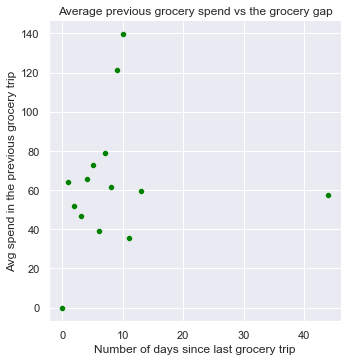

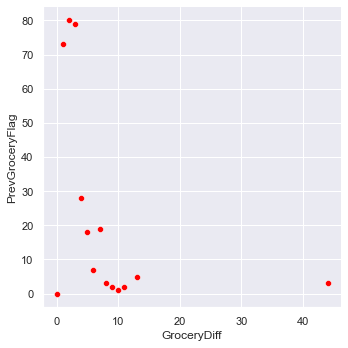

In [12]:
graphData = CCdata_merged_GR.groupby('GroceryDiff', as_index=False).agg({'PrevGroceryAmount':'mean',
                                                                        'PrevGroceryFlag':'sum'})
axes = sns.relplot(x="GroceryDiff", y="PrevGroceryAmount",color = "green", data=graphData)
axes.set(xlabel='Number of days since last grocery trip', ylabel='Avg spend in the previous grocery trip')
plt.title('Average previous grocery spend vs the grocery gap')
plt.show()
# plt.savefig('AvgPrevGroceryAmount_GroceryDiff.png')
sns.relplot(x="GroceryDiff", y="PrevGroceryFlag",color = "red", data=graphData)

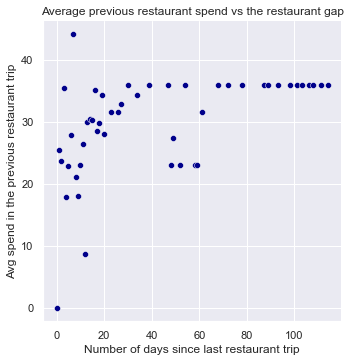

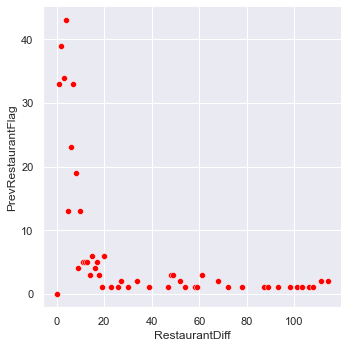

In [13]:
graphData = CCdata_merged_GR.groupby('RestaurantDiff', as_index=False).agg({'PrevRestaurantAmount':'mean',
                                                                        'PrevRestaurantFlag':'sum'})

axes = sns.relplot(x="RestaurantDiff", y="PrevRestaurantAmount",color = "darkblue", data=graphData, marker='o')
axes.set(xlabel='Number of days since last restaurant trip', ylabel='Avg spend in the previous restaurant trip')
plt.title('Average previous restaurant spend vs the restaurant gap')
plt.show()
# plt.savefig('AvgPrevRestaurantAmount_RestaurantDiff.png')
sns.relplot(x="RestaurantDiff", y="PrevRestaurantFlag",color = "red", data=graphData)

     Weekday  Grocery Amount  Restaurant Amount  Grocery Flag  Restaurant Flag
1     Monday       32.105652           4.697826      0.739130         0.260870
5    Tuesday       36.789730           2.698649      0.837838         0.162162
6  Wednesday       34.828571           3.273810      0.833333         0.166667
4   Thursday       44.210870           6.823043      0.782609         0.217391
0     Friday       48.578750           4.193500      0.775000         0.225000
2   Saturday       33.966286           9.497143      0.585714         0.414286
3     Sunday       34.991875           4.889167      0.708333         0.291667


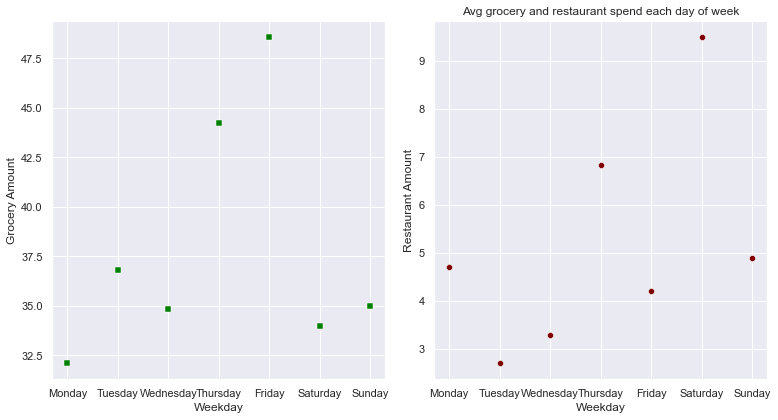

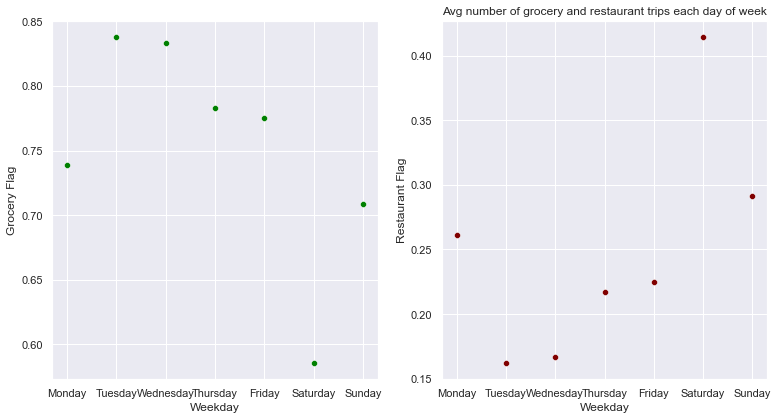

In [14]:
graphData = CCdata_merged_GR.groupby('Weekday', as_index=False).agg({'Grocery Amount':'mean',
                                                                    'Restaurant Amount':'mean',
                                                                    'Grocery Flag':'mean',
                                                                    'Restaurant Flag':'mean'})
## redefining Weekday column as a categorical variable with ordered levels, to order the points on the graph
graphData.Weekday = pd.Categorical(graphData.Weekday,
                            categories=['Monday', 'Tuesday', 'Wednesday',
                                        'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

graphData = graphData.sort_values('Weekday')
print(graphData)

plt.rcParams["figure.figsize"] = [11.00, 6.00]
plt.rcParams["figure.autolayout"] = True

# Weekday vs avg grocery and restaurant spend
f, axes = plt.subplots(1, 2)
sns.scatterplot(x="Weekday", y="Grocery Amount", color = "green", data=graphData, ax=axes[0],marker='s')
plt.title('Avg grocery and restaurant spend each day of week')
sns.scatterplot(x="Weekday", y="Restaurant Amount", color = "maroon", data=graphData, ax=axes[1])
plt.show()
# plt.savefig('Avgspend_weekday.png')

# weekday vs avg grocery and restaurant trips
f, axes = plt.subplots(1, 2)
sns.scatterplot(x="Weekday", y="Grocery Flag", color = "green", data=graphData, ax=axes[0])
plt.title('Avg number of grocery and restaurant trips each day of week')
sns.scatterplot(x="Weekday", y="Restaurant Flag", color = "maroon", data=graphData, ax=axes[1])
plt.show()
# plt.savefig('Avgtrips_weekday.png')

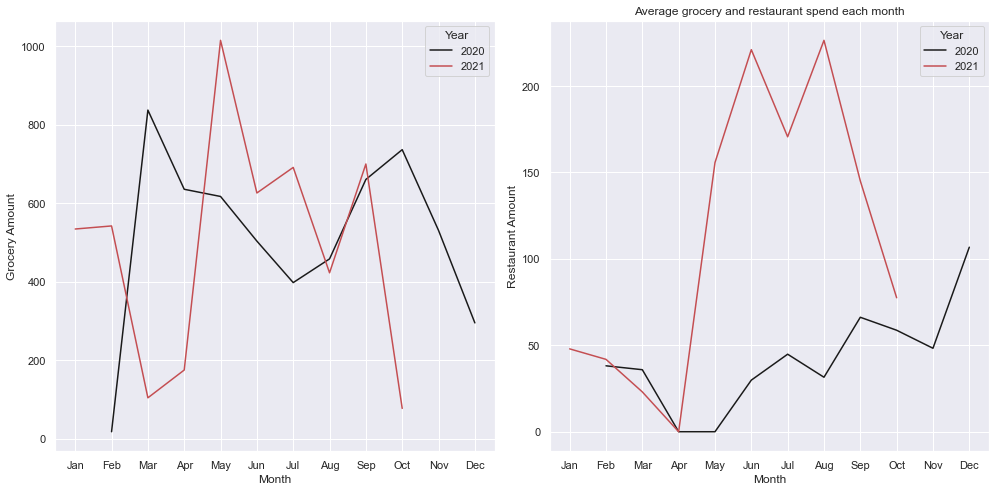

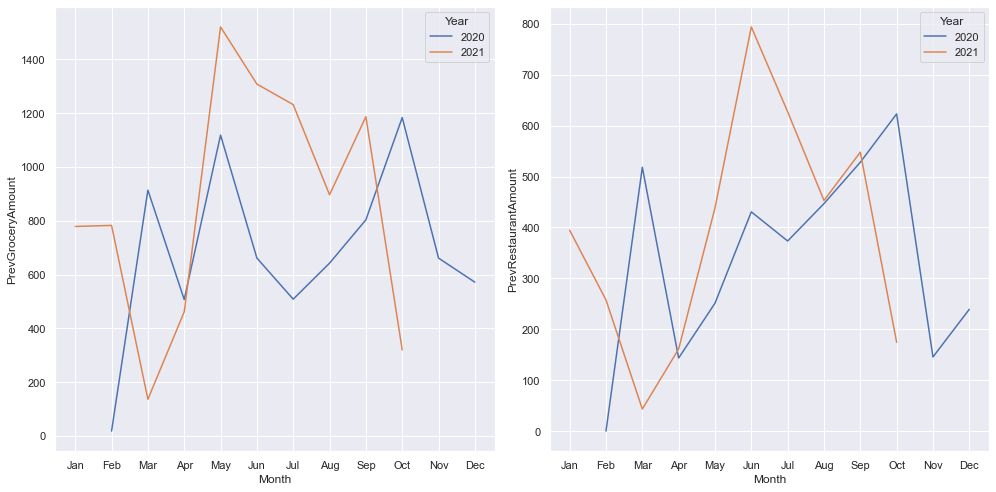

In [15]:
graphData = CCdata_merged_GR.groupby(['Month','Year'], as_index=False).agg({'Grocery Amount':'sum',
                                                                        'Restaurant Amount':'sum',
                                                                            'PrevGroceryAmount':'sum',
                                                                        'PrevRestaurantAmount':'sum'})
graphData['Month'] = pd.Categorical(graphData.Month,
                            categories=['Jan', 'Feb', 'Mar','Apr','May','Jun',
                                        'Jul','Aug','Sep','Oct','Nov','Dec'],
                            ordered=True)
graphData = graphData.sort_values('Month')

plt.rcParams["figure.figsize"] = [14.00, 7.00]
plt.rcParams["figure.autolayout"] = True

# Month vs avg grocery and restaurant spend
f, axes = plt.subplots(1, 2)
plt.title('Average grocery and restaurant spend each month')
sns.lineplot(x="Month", y="Grocery Amount", hue="Year", data=graphData, ax=axes[0], palette=["k", "r"])
sns.lineplot(x="Month", y="Restaurant Amount", hue="Year", data=graphData, ax=axes[1], palette=["k", "r"])
plt.show()
# plt.savefig('Avg monthly spend.png')

# Month vs avg prev grocery and prev restaurant spend
f, axes = plt.subplots(1, 2)
sns.lineplot(x="Month", y="PrevGroceryAmount", hue="Year", data=graphData, ax=axes[0], palette=["C0", "C1"])
sns.lineplot(x="Month", y="PrevRestaurantAmount", hue="Year", data=graphData, ax=axes[1], palette=["C0", "C1"])
plt.show()

    GroceryDiff  Grocery Amount  PrevGroceryAmount
0             0        9.040000           0.000000
1             1       31.852031          64.219844
2             2       33.808026          51.819605
3             3       31.959437          46.787887
4             4       54.471429          65.860952
5             5       36.963333          72.869333
6             6       42.614000          39.120000
7             7       62.524000          79.036667
8             8       50.886667          61.403333
9             9       75.450000         121.300000
10           10      167.260000         139.560000
11           11       34.150000          35.325000
12           13       76.926667          59.396667
13           44       21.793333          57.590000


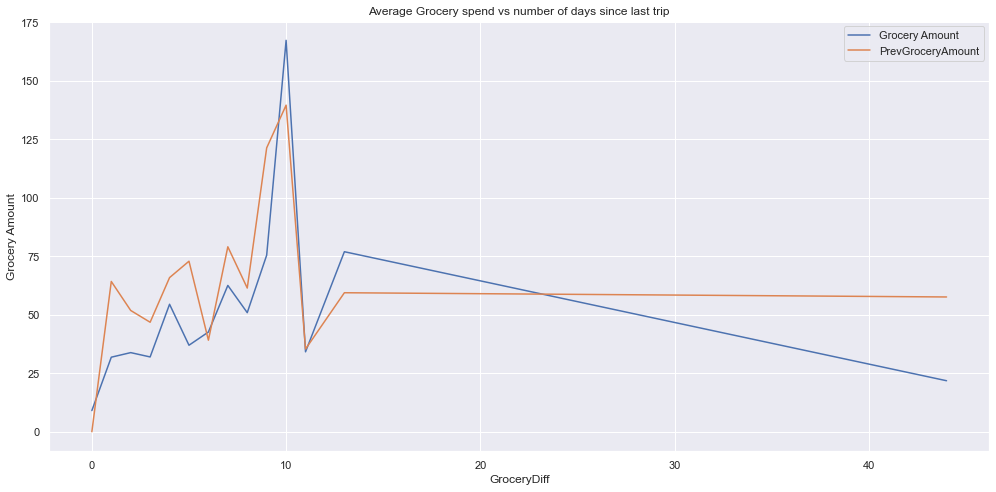

In [16]:
graphData = CCdata_merged_GR[['GroceryDiff','Grocery Amount','PrevGroceryAmount']].groupby('GroceryDiff', as_index=False).mean()
print(graphData)

plt.title('Average Grocery spend vs number of days since last trip')
sns.lineplot(x="GroceryDiff", y="Grocery Amount", data=graphData)
sns.lineplot(x="GroceryDiff", y="PrevGroceryAmount", data=graphData)
plt.legend(labels=["Grocery Amount","PrevGroceryAmount"])
# plt.savefig('Avgspend_grocerydiff.png')

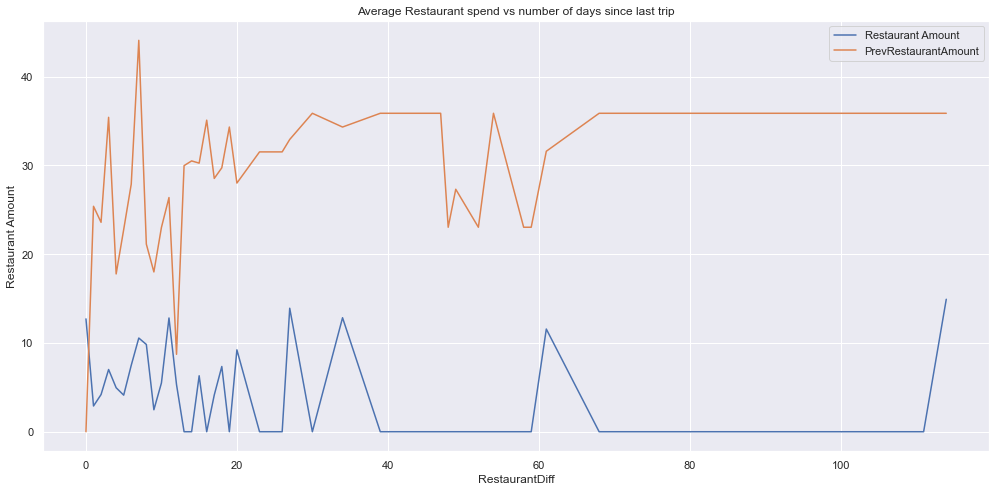

In [17]:
graphData = CCdata_merged_GR[['RestaurantDiff','Restaurant Amount','PrevRestaurantAmount']].groupby('RestaurantDiff', as_index=False).mean()

plt.title('Average Restaurant spend vs number of days since last trip')
sns.lineplot(x="RestaurantDiff", y="Restaurant Amount", data=graphData)
sns.lineplot(x="RestaurantDiff", y="PrevRestaurantAmount", data=graphData)
plt.legend(labels=["Restaurant Amount","PrevRestaurantAmount"])
# plt.savefig('Avgspend_restaurantdiff.png')

#### Outlier profile
From the plots we created so far, we can see that the potential regressors have outliers.
It is important to know the distribution profile of each variable in order to understand it behaviour and outcome in a model.

Let us find the significant percentile values of each column to understand the range of outliers and then plot their Kernel density estimations.

In [18]:
# Column descriptions for null and outlier correction
print(CCdata_merged_GR.columns)
print("The percentage of null values in each column: \n",CCdata_merged_GR.isnull().mean()*100)

# Filter columns that are to be regressed
featureData = CCdata_merged_GR[['TotalPrecip', 'MaxGust',
                                 'TempDiff','MeanTemp',
                                 'GroceryDiff','RestaurantDiff',
                                 'PrevGroceryAmount','PrevRestaurantAmount']]

print("Column decriptions: \n",featureData.describe())
quantileData = featureData.quantile([0.05,0.10,0.80,0.90,0.95,0.97,0.98,0.99])
print("Percentile values of columns: \n",quantileData)

Index(['Date', 'Transaction Date', 'Posting Date', 'Description', 'Amount',
       'Category', 'Month', 'Year', 'Day', 'Weekday', 'TotalPrecip',
       'TotalRain', 'TotalSnow', 'SnowGrnd', 'MaxGust', 'MaxTemp', 'MinTemp',
       'TempDiff', 'MeanTemp', 'Grocery Flag', 'PrevGroceryAmount',
       'PrevGroceryFlag', 'PrevGroceryDate', 'Restaurant Flag',
       'PrevRestaurantAmount', 'PrevRestaurantFlag', 'PrevRestaurantDate',
       'GroceryDiff', 'RestaurantDiff', 'Grocery Amount', 'Restaurant Amount'],
      dtype='object')
The percentage of null values in each column: 
 Date                     0.000000
Transaction Date         0.000000
Posting Date            43.109541
Description              0.000000
Amount                   0.000000
Category                 2.120141
Month                    0.000000
Year                     0.000000
Day                      0.000000
Weekday                  0.000000
TotalPrecip              0.000000
TotalRain                2.473498
TotalSnow   

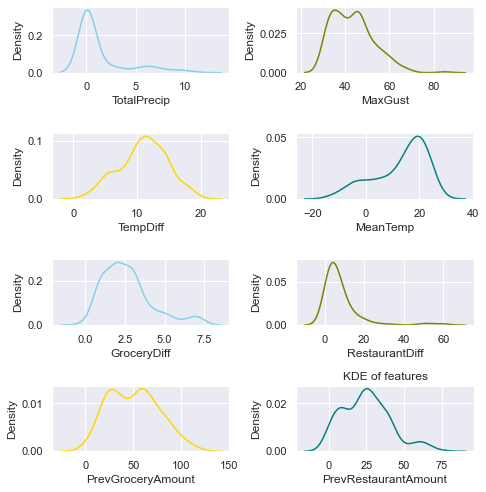

In [22]:
# Scatter plots of all variables that are to be regressed i.e featureData

# Get distribution plots of all the above columns in a multi-grid plot
f, axes = plt.subplots(4, 2, figsize=(7, 7))
plt.title('KDE of features')

sns.kdeplot(x=featureData["TotalPrecip"], color="skyblue", ax=axes[0, 0])
sns.kdeplot(x=featureData["MaxGust"], color="olive", ax=axes[0, 1])
sns.kdeplot(x=featureData["TempDiff"], color="gold", ax=axes[1, 0])
sns.kdeplot(x=featureData["MeanTemp"], color="teal", ax=axes[1, 1])
sns.kdeplot(x=featureData["GroceryDiff"], color="skyblue", ax=axes[2, 0])
sns.kdeplot(x=featureData["RestaurantDiff"], color="olive", ax=axes[2, 1])
sns.kdeplot(x=featureData["PrevGroceryAmount"], color="gold", ax=axes[3, 0])
sns.kdeplot(x=featureData["PrevRestaurantAmount"], color="teal", ax=axes[3, 1])

# plt.legend(labels=["TotalPrecip","MaxGust","TempDiff","MeanTemp",
#                    "GroceryDiff","RestaurantDiff","PrevGroceryAmount","PrevRestaurantAmount"])
plt.show()
# plt.savefig('KDE of features.png')

#### Outlier correction
Observations from the density plots: Total Precip, GroceryDiff, RestaurantDiff and PrevGroceryAmount are all heavily right skewed. Regression models are sensitive to outliers.
Solution: Looking at the percentile values of these columns, we can remove observations corresponding to >95%ile in these columns. Let us removing the last 5%ile of values off these columns. (%ile = percentile)

After correcting outliers, plot KDE of regressors to see if they resemble a normal distribution curve and also plot correlogram to get most influential regressors

In [20]:
# Observations from the density plots: Total Precip, GroceryDiff, RestaurantDiff and PrevGroceryAmount are all heavily right skewed
# Solution: Looking at the percentile values of these columns, we can remove observations corresponding to >95%ile in these columns
# Removing the last 5%ile of values of these columns
print(CCdata_merged_GR.shape)
CCdata_merged_GR[['OF1','OF2','OF3','OF4']] = 0
print(CCdata_merged_GR.shape)
CCdata_merged_GR.loc[(CCdata_merged_GR['TotalPrecip'] > CCdata_merged_GR['TotalPrecip'].quantile(.95)),'OF1'] = 1
CCdata_merged_GR.loc[(CCdata_merged_GR['GroceryDiff'] > CCdata_merged_GR['GroceryDiff'].quantile(.95)),'OF2'] = 1
CCdata_merged_GR.loc[(CCdata_merged_GR['RestaurantDiff'] > CCdata_merged_GR['RestaurantDiff'].quantile(.95)),'OF3'] = 1
CCdata_merged_GR.loc[(CCdata_merged_GR['PrevGroceryAmount'] > CCdata_merged_GR['PrevGroceryAmount'].quantile(.95)),'OF4'] = 1
print(CCdata_merged_GR['OF1'].sum())
print(CCdata_merged_GR['OF2'].sum())
print(CCdata_merged_GR['OF3'].sum())
print(CCdata_merged_GR['OF4'].sum())
# CCdata_merged_GR['OF'] = CCdata_merged_GR['OF1']+CCdata_merged_GR['OF2']+CCdata_merged_GR['OF3']+CCdata_merged_GR['OF4']
CCdata_merged_GR['OF'] = CCdata_merged_GR[['OF1','OF2','OF3','OF4']].sum(axis=1)
print(CCdata_merged_GR['OF'].sum())
print(CCdata_merged_GR.loc[CCdata_merged_GR['OF']>0,"OF"].count())

# Filter out outliers from CCdata_merged_GR
print(CCdata_merged_GR.shape)
CCdata_merged_GR = CCdata_merged_GR[CCdata_merged_GR['OF']==0]
print(CCdata_merged_GR.shape)

(283, 31)
(283, 35)
15
14
14
15
58
53
(283, 36)
(230, 36)


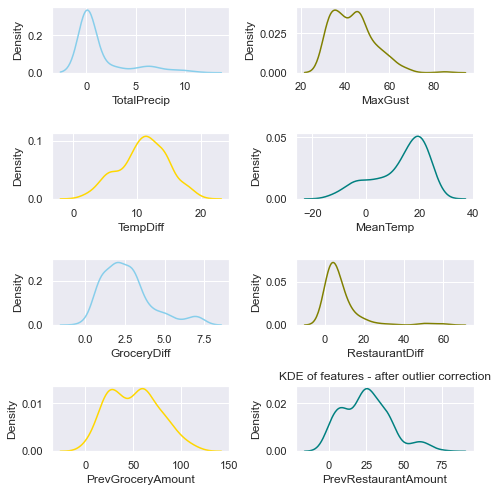

In [23]:
# Get distribution plots of columns to be regressed - after outlier removal
# Filter columns that are to be regressed
featureData = CCdata_merged_GR[['TotalPrecip', 'MaxGust',
                                 'TempDiff','MeanTemp',
                                 'GroceryDiff','RestaurantDiff',
                                 'PrevGroceryAmount','PrevRestaurantAmount']]

f, axes = plt.subplots(4, 2, figsize=(7, 7))
plt.title('KDE of features - after outlier correction')

sns.kdeplot(x=featureData["TotalPrecip"], color="skyblue", ax=axes[0, 0])
sns.kdeplot(x=featureData["MaxGust"], color="olive", ax=axes[0, 1])
sns.kdeplot(x=featureData["TempDiff"], color="gold", ax=axes[1, 0])
sns.kdeplot(x=featureData["MeanTemp"], color="teal", ax=axes[1, 1])
sns.kdeplot(x=featureData["GroceryDiff"], color="skyblue", ax=axes[2, 0])
sns.kdeplot(x=featureData["RestaurantDiff"], color="olive", ax=axes[2, 1])
sns.kdeplot(x=featureData["PrevGroceryAmount"], color="gold", ax=axes[3, 0])
sns.kdeplot(x=featureData["PrevRestaurantAmount"], color="teal", ax=axes[3, 1])

# plt.legend(labels=["TotalPrecip","MaxGust","TempDiff","MeanTemp",
#                    "GroceryDiff","RestaurantDiff","PrevGroceryAmount","PrevRestaurantAmount"])
plt.show()
# plt.savefig('KDE_after outlier correction.png')

Correlation matrix:  Grocery Amount          1.000000
TotalPrecip             0.011990
MaxGust                 0.121468
TempDiff               -0.052612
MeanTemp               -0.115862
WeekdayNumber          -0.028126
GroceryDiff             0.105346
RestaurantDiff          0.008993
PrevGroceryAmount       0.040160
PrevRestaurantAmount   -0.044704
Name: Grocery Amount, dtype: float64


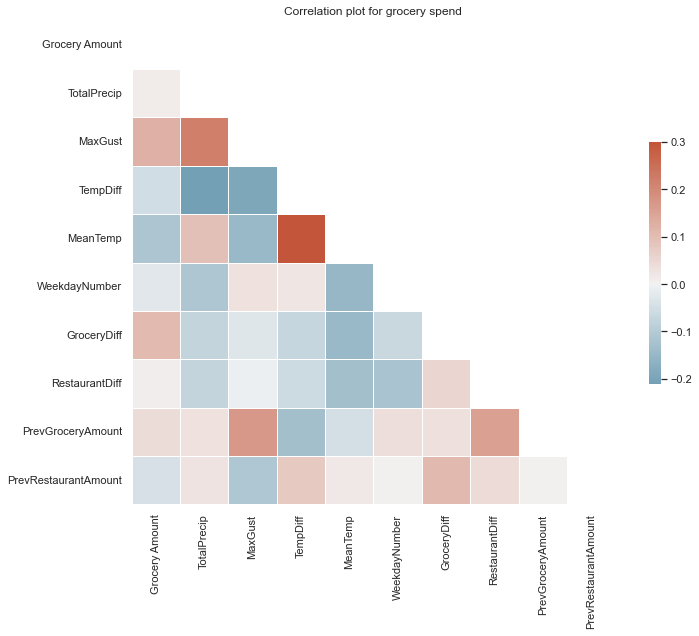

In [24]:
# Adding weekday number as a column in CCdata_merged_GR
CCdata_merged_GR['WeekdayNumber'] = CCdata_merged_GR['Date'].dt.weekday 

## Correlation plot of features vs gorceryamount and restaurant amount
sns.set_theme(style="white")

# filter required columns
groceryfeatures = CCdata_merged_GR[['Grocery Amount', 'TotalPrecip', 'MaxGust',
                                 'TempDiff','MeanTemp', 'WeekdayNumber',
                                 'GroceryDiff','RestaurantDiff',
                                 'PrevGroceryAmount','PrevRestaurantAmount']]

restaurantfeatures = CCdata_merged_GR[['Restaurant Amount', 'TotalPrecip', 'MaxGust',
                                 'TempDiff','MeanTemp', 'WeekdayNumber',
                                 'GroceryDiff','RestaurantDiff',
                                 'PrevGroceryAmount','PrevRestaurantAmount']]

# Compute the correlation matrix
corrGrocery = groceryfeatures.corr()
corrRestaurant = restaurantfeatures.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrGrocery, dtype=bool))

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(11, 9))
plt.title('Correlation plot for grocery spend')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrGrocery, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print("Correlation matrix: ", corrGrocery['Grocery Amount'])
# plt.savefig('Correlation plot_grocery spend.png')

Correlation matrix:  Restaurant Amount       1.000000
TotalPrecip            -0.020662
MaxGust                 0.011090
TempDiff               -0.005101
MeanTemp                0.066212
WeekdayNumber           0.128377
GroceryDiff            -0.063150
RestaurantDiff          0.032039
PrevGroceryAmount       0.081725
PrevRestaurantAmount    0.018491
Name: Restaurant Amount, dtype: float64


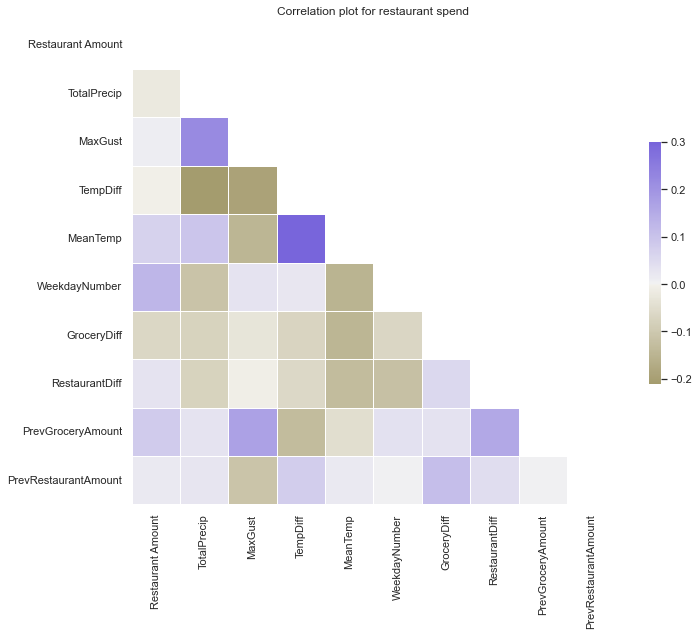

In [25]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(11, 9))
plt.title('Correlation plot for restaurant spend')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(435, 270, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrRestaurant, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print("Correlation matrix: ", corrRestaurant['Restaurant Amount'])
# plt.savefig('Correlation plot_restaurant spend.png')

#### Split train and test data

Create an 80% - 20% train-test split. 
To get train and test data for non-time series data, we could use train_test_split() from sklearn or use sample() function to generate random sample of integers which could be used to filter a dataframe.

To split a time series dataset into train and test data, we simply split it by the total time.


In [26]:
# Splitting train and test data - 80%-20% split
traindata = CCdata_merged_GR.loc[CCdata_merged_GR['Grocery Flag']==1,]
traindata = traindata[['Date','Grocery Amount', 'MaxGust',
                                 'MeanTemp',
                                 'GroceryDiff']]
print(traindata.shape)

sample80 = int(len(traindata)*0.8)
testdata = df[sample80:]
traindata = df[:sample80]

print(f"No. of training examples: {traindata.shape[0]}")
print(f"No. of testing examples: {testdata.shape[0]}")

print("The percentage of null values in each column: \n",traindata.isnull().mean()*100)

(164, 5)
No. of training examples: 128
No. of testing examples: 36
The percentage of null values in each column: 
 Date              0.0
Grocery Amount    0.0
MaxGust           0.0
MeanTemp          0.0
GroceryDiff       0.0
dtype: float64


In [27]:
## Fitting linear regression model with regressors

#Setting target and regression variables up
y = traindata['Grocery Amount']
X = traindata[['MaxGust', 'MeanTemp', 'GroceryDiff']]
# X = traindata[['TotalPrecip', 'MaxGust',
#                 'TempDiff','MeanTemp', 'WeekdayNumber',
#                 'GroceryDiff','RestaurantDiff',
#                 'PrevGroceryAmount','PrevRestaurantAmount']]

linr_model = LinearRegression().fit(X, y)
print(linr_model.fit)

# Model coefficient and intercept
print(linr_model.coef_)
print(linr_model.intercept_)

<bound method LinearRegression.fit of LinearRegression()>
[ 0.23917245 -0.19412481  2.01855603]
34.58572042498045


In [28]:
rsq = linr_model.score(X, y)
print('Coefficient of determination:', rsq)  #coefficient of determination: 0.04966561744361031 with all factors and 0.013710796943476322 with only 3 factors

Coefficient of determination: 0.011687842765215617


         Date  Actual  MaxGust  MeanTemp  GroceryDiff  Predicted
4  2020-03-01   35.45     33.0      -4.3            7  57.443040
6  2020-03-03   14.46     48.0       2.9            1  47.521592
8  2020-03-07   35.26     33.0      -3.4            2  47.175548
40 2020-07-04   49.13     37.0      24.5            4  46.753268
43 2020-07-10   39.60     61.0      27.1            2  47.951570
51 2020-07-25   38.69     46.0      22.7            3  47.236688
60 2020-08-12    4.85     33.0      20.4            4  46.592489
64 2020-08-21   59.56     35.0      20.7            2  42.975485
65 2020-08-24   44.33     39.0      24.3            3  45.251881
66 2020-08-26   15.93     32.0      17.5            2  42.879167


Text(0.5, 1.0, 'Actual vs Predicted values - simple linear regression')

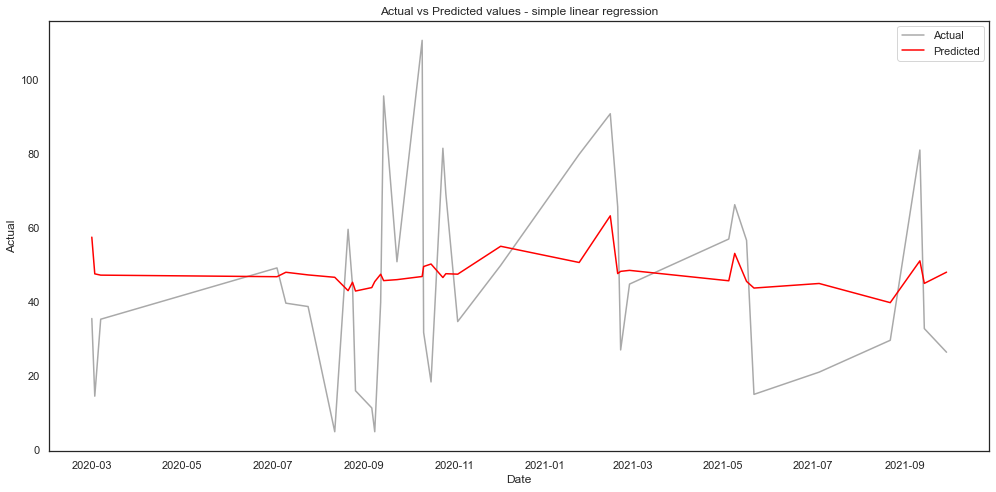

In [29]:
test_pred = linr_model.predict(testdata[['MaxGust', 'MeanTemp', 'GroceryDiff']])
# print('Predicted values:', test_pred, sep='\n')
# print('Actual values:', testdata['Grocery Amount'], sep='\n')
testdata['Predicted'] = test_pred
testdata = testdata.rename({'Grocery Amount': 'Actual'}, axis=1)
print(testdata.head(10))
sns.lineplot(x='Date',y='Actual',data = testdata, color='darkgrey')
sns.lineplot(x='Date',y='Predicted',data = testdata, color='red')
plt.legend(labels=["Actual","Predicted"])
plt.title("Actual vs Predicted values - simple linear regression")
# plt.savefig("Actual vs Predicted values - simple linear regression.png")

In [30]:
import statsmodels.api as sm

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params) #Adjusted R2 in this model is 57.1% - which is much higher than 1.6% in the simple linear model

                                 OLS Regression Results                                
Dep. Variable:         Grocery Amount   R-squared (uncentered):                   0.566
Model:                            OLS   Adj. R-squared (uncentered):              0.556
Method:                 Least Squares   F-statistic:                              54.33
Date:                Thu, 11 Aug 2022   Prob (F-statistic):                    1.51e-22
Time:                        16:41:44   Log-Likelihood:                         -660.64
No. Observations:                 128   AIC:                                      1327.
Df Residuals:                     125   BIC:                                      1336.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

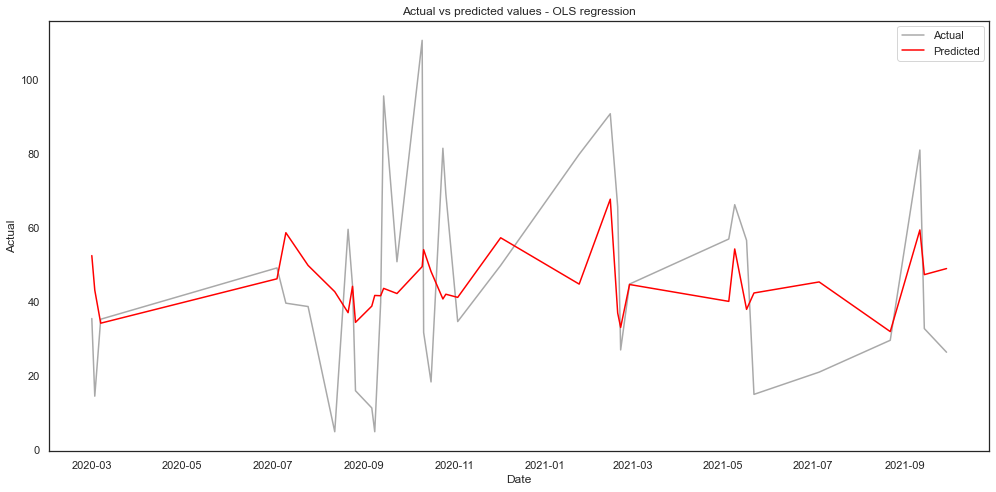

In [31]:
test_pred = results.predict(testdata[['MaxGust', 'MeanTemp', 'GroceryDiff']])
testdata['PredictedOLS'] = test_pred
sns.lineplot(x='Date',y='Actual',data=testdata, color='darkgrey')
sns.lineplot(x='Date',y='PredictedOLS', data=testdata, color='red')
plt.title('Actual vs predicted values - OLS regression')
plt.legend(labels=['Actual','Predicted'])
# plt.savefig("Actual vs predicted values - OLS regression.png")

In [32]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='rbf')
regressor.fit(X,y)

# print(regressor))
#5 Predicting a new result
svm_pred = regressor.predict(testdata[['MaxGust', 'MeanTemp', 'GroceryDiff']])


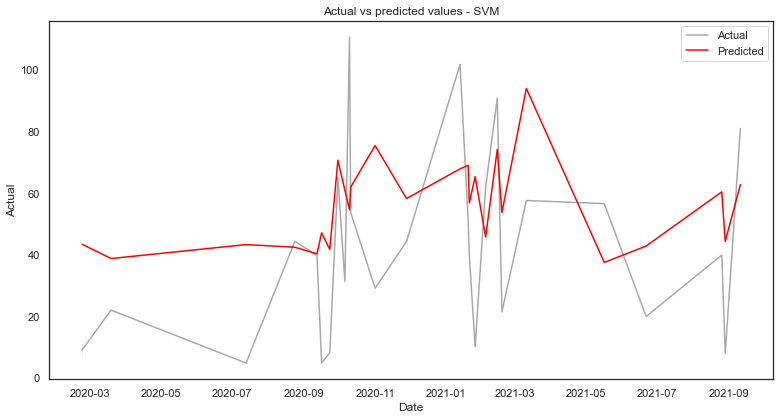

In [47]:
testdata['PredictedSVM'] = svm_pred
sns.lineplot(x='Date',y='Actual',data=testdata, color='darkgrey')
sns.lineplot(x='Date',y='PredictedOLS', data=testdata, color='red')
plt.title('Actual vs predicted values - SVM')
plt.legend(labels=['Actual','Predicted'])
# plt.savefig("Actual vs predicted values - SVM.png")

In [33]:
# Studying regressors before and after Box-cox transformation
# Filter columns that are to be regressed
featureData = CCdata_merged_GR[['TotalPrecip', 'MaxGust',
                                 'TempDiff','MeanTemp',
                                 'GroceryDiff','RestaurantDiff',
                                 'PrevGroceryAmount','PrevRestaurantAmount']]
# skewness and kurtosis of features
print("Features: ",featureData.columns)
print("Skewness of features: ", stats.skew(featureData, bias=False))
print("Kurtosis of features: ", stats.kurtosis(featureData, bias=False))

# apply box-cox transformation on featureData - can be done 
print(featureData['TotalPrecip'].describe())
boxcoxFeatures = featureData['TotalPrecip'][featureData['TotalPrecip']>0]
boxcoxFeatures, bestLambda = stats.boxcox(boxcoxFeatures)
print(boxcoxFeatures)
featureData['TotalPrecipbxcx'] = 0
featureData[(featureData['TotalPrecip']>0),'TotalPrecipbxcx'] = boxcoxFeatures
featureData[(featureData['TotalPrecip'] == 0),'TotalPrecipbxcx'] = (-1/bestLambda)
print(stats.skew(boxcoxFeatures, bias=False))
print(stats.kurtosis(boxcoxFeatures, bias=False))

Features:  Index(['TotalPrecip', 'MaxGust', 'TempDiff', 'MeanTemp', 'GroceryDiff',
       'RestaurantDiff', 'PrevGroceryAmount', 'PrevRestaurantAmount'],
      dtype='object')
Skewness of features:  [ 1.97772244  0.84195745 -0.22247953 -0.83971092  1.14953653  3.2653773
  0.25180948  0.57224082]
Kurtosis of features:  [ 2.81163695  0.93191528 -0.37985017 -0.34618771  1.12412229 12.21817756
 -0.70667954  0.17205788]
count    230.000000
mean       1.366522
std        2.614665
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       11.000000
Name: TotalPrecip, dtype: float64
[ 3.01455184  1.09234312  2.6664604   1.1896287   2.36750135  2.31367169
  2.31367169  2.14394508  2.31367169  1.75835383  2.08433144  1.28199332
  1.28199332 -0.81026521  0.50162736 -1.3013093  -1.3013093  -1.3013093
  2.93203306  2.93203306 -0.47666991 -1.3013093  -0.21645528 -0.21645528
  2.471489    2.52177449 -0.81026521  0.          2.36750135  1.1896287
  3.32021498  0.        

C:\Users\Nalina\AppData\Local\Temp/ipykernel_19696/265142686.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureData['TotalPrecipbxcx'] = 0


ValueError: Length of values (86) does not match length of index (230)

In [ ]:
# Get distribution plots of all the above columns in a multi-grid plot
f, axes = plt.subplots(4, 2, figsize=(7, 7))
plt.title('KDE of features after box-cox transformation')

sns.kdeplot(x=featureData["TotalPrecip"], color="skyblue", ax=axes[0, 0])
sns.kdeplot(x=featureData["MaxGust"], color="olive", ax=axes[0, 1])
sns.kdeplot(x=featureData["TempDiff"], color="gold", ax=axes[1, 0])
sns.kdeplot(x=featureData["MeanTemp"], color="teal", ax=axes[1, 1])
sns.kdeplot(x=featureData["GroceryDiff"], color="skyblue", ax=axes[2, 0])
sns.kdeplot(x=featureData["RestaurantDiff"], color="olive", ax=axes[2, 1])
sns.kdeplot(x=featureData["PrevGroceryAmount"], color="gold", ax=axes[3, 0])
sns.kdeplot(x=featureData["PrevRestaurantAmount"], color="teal", ax=axes[3, 1])

plt.show()
# plt.savefig('KDE of features_Box cox transformed.png')